In [1]:
import numpy as np
import sklearn 
import math
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate

'''加载文件'''
def loadData(filePath):
    file = open(filePath,'rb')
    data = file.read()
    file.close()
    return data

'''得到所有文件名'''
def getFileList(rootPath):
    fileList_temp = []
    for root, dirs, files in os.walk(rootPath):
        fileList_temp.append(files)
    fileList = []
    for filter in fileList_temp[0]:
        if filter.split('.')[1] == 'txt':
            fileList.append(rootPath+'/'+filter)
    return fileList

'''把得到的加速度,角速度,标签，写入到文件中'''
def write2file(X,Y,X_path,Y_path):
    np.savetxt(X_path,X,delimiter=',')
    np.savetxt(Y_path,Y,delimiter=',')
    
    
'''从文件中获取加速度和角速度'''
def getAandG(data):
    data_len = len(data)
    a = [[] for i in range(3)]  # 加速度
    w = [[] for i in range(3)]  # 角速度
    index = 0
    while index < data_len:  
        if data[index] == 0x55:  # 包头
#             print("包头")
            if index + 7 < data_len:
                temp_a = data[index+3]
                temp_b = data[index+5]
                temp_c = data[index+7]
                if data[index+3] > 127:  # 说明是负数
                    temp_a = temp_a - 256
                if data[index+5] >127:
                    temp_b = temp_b - 256
                if data[index+7] >127:
                    temp_c = temp_c - 256
                if data[index+1] == 81: # 加速度输出
                    a[0].append(temp_a*256+data[index+2]) # x轴加速度
                    a[1].append(temp_b*256+data[index+4]) # y轴加速度
                    a[2].append(temp_c*256+data[index+6]) # z轴加速度
#                     print("a[x]=%d,a[y]=%d,a[z]=%d"%(a[0][-1],a[1][-1],a[2][-1]))
                    index += 11
                    continue
                elif data[index+1] == 82: # 角速度输出
                    w[0].append(temp_a*256+data[index+2]) # x轴角速度
                    w[1].append(temp_b*256+data[index+4]) # y轴角速度
                    w[2].append(temp_c*256+data[index+6]) # z轴角速度
#                     print("w[x]=%d,w[y]=%d,w[z]=%d"%(w[0][-1],w[1][-1],w[2][-1]))
                    index += 11
                    continue
                elif data[index+1] == 83: # 角度输出
                    index += 11
                else:  # 或者数据有丢失
                    index += 1
            else:  # 没有完整的数据了
                break
        else:  # 数据有丢失
            index += 1
    a = np.array(a)
    w = np.array(w)
    a = a / 32768 * 16    #单位为g
    w = w / 32768 * 2000  # 单位为°/s
    #print(a.shape+w.shape)
    return a,w

'''从文件中获取标签'''
def getLabel(data):
   
    return a,w

'''获取指定目录下的原始数据，将转换后的数据合并成一个张量
   rootPath为目标路径，start-起始文件，end-截至文件
'''
def convertData(fileList,start=-1,end=-1):
    acc = np.empty((3,0))#创建一个空数组，用于存放加速度的集合
    rad = np.empty((3,0))
    if(end>start&start>0):
        targetFiles = fileList[start:end]
    else:
        targetFiles=fileList
        
    for filePath in targetFiles:
        #filePath = rootPath+'/'+file
        data = loadData(filePath)
        a,w = getAandG(data)
        len_diff = len(a[1])-len(w[1])
        if len_diff !=0:#数据对齐
            if len_diff>0:#加速度数据长
                w = np.hstack((w,np.zeros((3,len_diff))))
            elif len_diff<0:#角速度数据长
                a = np.hstack((a,np.zeros((3,-len_diff))))   
#         print(len(a[1])==len(w[1]))#判断是否对齐
# 将数据前后100各采样点换成0 ，消除上电断电对数据的影响
        a,w = cutSEpoint(a,w)
        #print(acc.shape+rad.shape)
        acc = np.hstack((acc,a))
        rad = np.hstack((rad,w))
    print(acc.shape+rad.shape)
    return acc,rad

'''将数据前后100各采样点换成0 ，消除上电断电对数据的影响'''
def cutSEpoint(acc,rad,lenth=100):
    for i in range(lenth):
        acc[0][i]=0
        acc[1][i]=0
        acc[2][i]=0
        rad[0][i]=0
        rad[1][i]=0
        rad[2][i]=0
        acc[0][-i]=0
        acc[1][-i]=0
        acc[2][-i]=0
        rad[0][-i]=0
        rad[1][-i]=0
        rad[2][-i]=0
    return acc,rad

'''三轴数据画图'''
def showPic(data):
    plt.figure(figsize=(20,15))
    plt.plot(range(0,len(data[0])),data[0],'r',range(0,len(data[1])),data[1],'g',range(0,len(data[2])),data[2],'b')
    label=["X","Y","Z"]
    plt.legend(label,loc=0,ncol=2)
#     plt.savefig("三轴数据滤波&切割后波形",dpi=600)
    plt.show()

'''过低通滤波'''
def smoothing(data,n=3,wn=0.02):
    b,a = signal.butter(n,wn,'low')  
    sf = signal.filtfilt(b,a,data)
    return sf

'''分割算法——acc,rad为待分隔数据，windowlen为窗口大小，strides为单步滑动大小，
threshold1为用于定义切断信号状态的阈值,threshold2用于定义窗口内有多少个1时判断为1'''
def getSegFun(acc,rad,windowlen=100,strides=100,threshold1=6,threshold2=50):
    #用于保存各动作起点终点位置
    start_point =[]
    end_point = []
    pointSignal = np.arange(len(rad[1]))#声明一个切断信号,因为六轴数据已经对齐，数据长度相同，所以统一用rad[1]的长度代表整体长度
    for i in range(len(rad[1])):
        tmp= abs(rad[0][i])+abs(rad[1][i])+abs(rad[2][i])#只是其中一种方法
       # tmp= math.sqrt(abs(rad[0][i])**2+abs(rad[1][i])**2+abs(rad[2][i])**2)#只是其中一种方法
        if(tmp>threshold1):
            pointSignal[i]=1
        else:
            pointSignal[i]=0
    state = 0
    window = np.arange(windowlen)
    for i in range(0,len(pointSignal),strides):
        if(i+strides<len(pointSignal)):
            window = pointSignal[i:i+strides]
            if(np.sum(window)>threshold2):
                pointSignal[i:i+strides]=1
                if(state==0):#状态转换时，留出一小段保留数据。
                    pointSignal[i-100:i]=1
                state = 1
            else:
                pointSignal[i:i+strides]=0
                if(state==1):#状态转换时，留出一小段保留数据。
                    pointSignal[i:i+100]=1
                state = 0
        else:
            window = pointSignal[i:]
            if(np.sum(window)>threshold2):
                pointSignal[i:]=1
            else:
                pointSignal[i:]=0
    return pointSignal

'''获取切割端点'''
def getEndPoint(pointSignal):  
    # 用于保存各动作起点终点位置
    start_point =[]
    end_point = []
    # 状态位
    state = 0
    for i in range(len(pointSignal)):
        if(state == 0 and pointSignal[i] == 1):
            start_point.append(i)
            state = 1
        elif(state == 1 and pointSignal[i] == 0):
            end_point.append(i)
            state = 0
    #print("切割段数：%d"%len(end_point))
    #print(len(start_point))
    return start_point,end_point

'''切割方法，超参调优函数'''
def segFunhyper():
    windowlen = []
    threshold1 = []
    threshold2 = []
    max_lenth =[]
    pointSignal = []
    for w in range(50,100):
        for t1 in range(2,10):
            for t2 in range(10,100): 
                p = getSegFun(s_acc,s_rad,windowlen=w,strides=100,threshold1=t1,threshold2=t2)
                pointSignal.append(p)
                start_point,end_point = getEndPoint(p)
                if(len(start_point)==107): 
                    '''3.切分数据'''
                    #输出最大长度
                    lenth = 0 
                    for i in range(len(end_point)):
                        if(lenth < end_point[i]- start_point[i]):
                            lenth = end_point[i]- start_point[i]
                    max_lenth.append(lenth)
                    print("window:%d  t1:%d  t2:%d  最大长度：%d"%(w,t1,t2,lenth))
                    windowlen.append(w)
                    threshold1.append(t1)
                    threshold2.append(t2)
    #写入文件                
    file = open('max_lenth.txt','w+')
    file.write(str(max_lenth))
    file.close()
    file = open('windowlen.txt','w+')
    file.write(str(windowlen))
    file.close()
    file = open('threshold1.txt','w+')
    file.write(str(threshold1))
    file.close()
    file = open('threshold2.txt','w+')
    file.write(str(threshold2))
    file.close()
    file = open('pointSignal.txt','w+')
    file.write(str(pointSignal))
    file.close()

'''三轴数据画图'''
def showPic(data,title="三轴数据画图"):
    plt.figure(figsize=(20,15))
    plt.plot(range(0,len(data[0])),data[0],'r',range(0,len(data[1])),data[1],'g',range(0,len(data[2])),data[2],'b')
    label=["X","Y","Z"]
    plt.legend(label,loc=0,ncol=2)
    plt.title(title)
#     plt.savefig("三轴数据滤波&切割后波形",dpi=600)
    plt.show()

In [2]:
#加载数据
fileList = getFileList("E:/Car data/data/11.6/X")
fileList +=getFileList("E:/Car data/data/11.15/X")
fileList +=getFileList("E:/Car data/data/11.25/X")
fileList +=getFileList("E:/Car data/data/12.3/X")
print("样本个数：%d"%len(fileList))
#showPic(acc)
#np.loadtxt("E:/Car data/data/11.25/Y/label.txt").astype(np.int).reshape(-1,1)

样本个数：107


In [3]:
#数据预处理
acc,rad = convertData(fileList)
'''1.过低通滤波器'''
s_acc = smoothing(acc,n=3,wn=0.02)
s_rad = smoothing(rad,n=3,wn=0.02)
'''2.根据平滑后的数据进行切断，并获取端点'''
#pointSignal = getSegFun(s_acc,s_rad,windowlen=100,strides=100,threshold1=3,threshold2=57)
# 优化超参后的切断
pointSignal = getSegFun(s_acc,s_rad,windowlen=60,strides=100,threshold1=4,threshold2=58)
start_point,end_point = getEndPoint(pointSignal)
'''3.切分数据'''
X = np.empty((107,6,3000))
Y = np.array((107,1))
#输出最大长度，最大长度 3000
'''4.数据对齐、合并'''
for i in range(len(end_point)):
    acc_tem = np.array(s_acc[:,start_point[i]:end_point[i]])
    rad_tem = np.array(s_rad[:,start_point[i]:end_point[i]])
    #print(acc_tem.shape)
    new_index = np.arange(3000)
    raw_index = np.linspace(0,3000,acc_tem[0].size)
    #print(raw_index)
    f_a1 = interpolate.interp1d(raw_index, acc_tem[0], kind='cubic')
    f_a2 = interpolate.interp1d(raw_index, acc_tem[1], kind='cubic')
    f_a3 = interpolate.interp1d(raw_index, acc_tem[2], kind='cubic')
    f_r1 = interpolate.interp1d(raw_index, rad_tem[0], kind='cubic')
    f_r2 = interpolate.interp1d(raw_index, rad_tem[1], kind='cubic')
    f_r3 = interpolate.interp1d(raw_index, rad_tem[2], kind='cubic')
    
    X[i][0] = f_a1(new_index)
    X[i][1] = f_a2(new_index)
    X[i][2] = f_a3(new_index)
    X[i][3] = f_r1(new_index)
    X[i][4] = f_r2(new_index)
    X[i][5] = f_r3(new_index)
print(X.shape)
np.save("E:/Car data/data/all/X", X)

(3, 182158, 3, 182158)
(107, 6, 3000)


In [4]:
'''5.获取标签数据'''
#加载数据
fileList = ["E:/Car data/data/11.6/Y/Label.txt","E:/Car data/data/11.15/Y/Label.txt","E:/Car data/data/11.25/Y/Label.txt","E:/Car data/data/12.3/Y/Label.txt"]
for i,file in enumerate(fileList):
    if(i==0):
        y_tem = np.loadtxt(file,delimiter='\r\n',dtype=np.int).reshape(-1,1)
    else:
        y_tem = np.concatenate((y_tem,np.loadtxt(file,delimiter='\r\n',dtype=np.int).reshape(-1,1)),axis = 0)
Y = y_tem
print("标签数据：%d" % (Y.shape[0]))
np.save("E:/Car data/data/all/Y", Y)

标签数据：107


In [5]:
'''6.拆分训练集、测试集'''
from sklearn.cross_validation import train_test_split  
X_train , X_test , y_train , y_test = train_test_split(X,Y,test_size=0.2, random_state=0)
print("训练样本大小：%d" % X_train.shape[0])
print(X_train.shape)
print("测试集大小：%d" % X_test.shape[0])
print(X_test.shape)

训练样本大小：85
(85, 6, 3000)
测试集大小：22
(22, 6, 3000)


C:\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


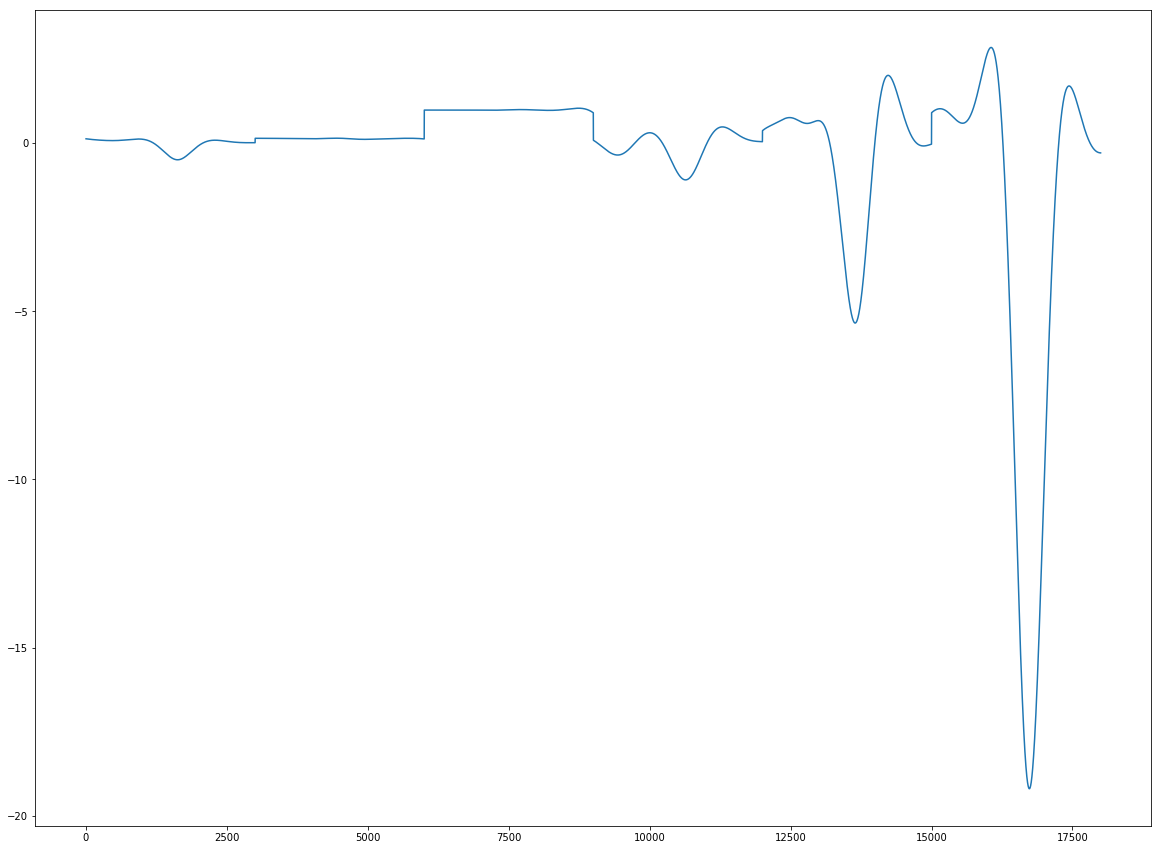

In [8]:
'''7.数据处理--标准化'''
X_train_shift = X_train.reshape(X_train.shape[0],-1)
X_test_shift = X_test.reshape(X_test.shape[0],-1)
scaler = sklearn.preprocessing.StandardScaler().fit(X_train_shift)
scaler.transform(X_train_shift)
scaler.transform(X_test_shift)

'''数据画图'''
plt.figure(figsize=(20,15))
plt.plot(range(0,len(X_train_shift[1])),X_train_shift[1])
plt.show()
    
# showPic(X_train[4,0:3,:],)

In [10]:

# X_train , X_test , y_train , y_test
'''knn:'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
knn = KNeighborsClassifier()
knn.fit(X_train_shift, y_train)
knn_labels = knn.predict(X_test_shift)
print(classification_report(y_test, knn_labels))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         5
          2       0.50      1.00      0.67         3
          3       0.00      0.00      0.00         3
          4       0.40      0.50      0.44         4
          5       0.67      0.57      0.62         7

avg / total       0.35      0.41      0.37        22



C:\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


In [14]:

'''DesicisionTree:'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

dt = DecisionTreeClassifier()
#cross_val_score(dt, X_train_shift, y_train, cv =10)
dt.fit(X_train_shift, y_train)
dt_labels = dt.predict(X_test_shift)
print(classification_report(y_test, dt_labels))

             precision    recall  f1-score   support

          1       0.33      0.20      0.25         5
          2       0.33      0.33      0.33         3
          3       0.20      0.33      0.25         3
          4       0.40      0.50      0.44         4
          5       0.67      0.57      0.62         7

avg / total       0.43      0.41      0.41        22



In [12]:
'''Naive Bayes:'''
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
gnb = GaussianNB()
gnb.fit(X_train_shift, y_train)
gnb_labels = gnb.predict(X_test_shift)
print(classification_report(y_test, gnb_labels))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         5
          2       0.29      0.67      0.40         3
          3       0.00      0.00      0.00         3
          4       0.40      0.50      0.44         4
          5       0.57      0.57      0.57         7

avg / total       0.29      0.36      0.32        22



C:\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
#数据预处理
acc,rad = convertData(fileList)
'''1.过低通滤波器'''
s_acc = smoothing(acc,n=3,wn=0.02)
s_rad = smoothing(rad,n=3,wn=0.02)
'''2.根据平滑后的数据进行切断，并获取端点'''
#pointSignal = getSegFun(s_acc,s_rad,windowlen=100,strides=100,threshold1=3,threshold2=57)
pointSignal = getSegFun(s_acc,s_rad,windowlen=80,strides=100,threshold1=5,threshold2=22)
start_point,end_point = getEndPoint(pointSignal)
#画出切断函数
# plt.figure(figsize=(20,15))
# plt.plot(range(0,len(pointSignal)),pointSignal)
# plt.show()

(3, 182158, 3, 182158)
切割段数：107


In [39]:
'''3.切分数据'''
#输出最大长度
max_lenth = 0 
for i in range(len(end_point)):
    if(max_lenth < end_point[i]- start_point[i]):
        max_lenth = end_point[i]- start_point[i]
print("单个样本最大长度：%d" % max_lenth)



单个样本最大长度：4800


In [40]:
for i in range(len(end_point)):
    aaa = s_acc[:,start_point[i]:end_point[i]]
    print(aaa.shape)

(3, 700)
(3, 500)
(3, 500)
(3, 500)
(3, 400)
(3, 1500)
(3, 1600)
(3, 1400)
(3, 1800)
(3, 400)
(3, 300)
(3, 400)
(3, 300)
(3, 300)
(3, 800)
(3, 300)
(3, 400)
(3, 500)
(3, 900)
(3, 700)
(3, 300)
(3, 600)
(3, 800)
(3, 700)
(3, 800)
(3, 400)
(3, 500)
(3, 500)
(3, 300)
(3, 1500)
(3, 2100)
(3, 2200)
(3, 2100)
(3, 2300)
(3, 300)
(3, 2200)
(3, 300)
(3, 1900)
(3, 300)
(3, 800)
(3, 800)
(3, 300)
(3, 500)
(3, 600)
(3, 300)
(3, 800)
(3, 500)
(3, 600)
(3, 700)
(3, 700)
(3, 700)
(3, 400)
(3, 300)
(3, 500)
(3, 600)
(3, 400)
(3, 400)
(3, 300)
(3, 400)
(3, 300)
(3, 2300)
(3, 300)
(3, 4800)
(3, 2300)
(3, 300)
(3, 2500)
(3, 2800)
(3, 2500)
(3, 2100)
(3, 2300)
(3, 300)
(3, 2300)
(3, 400)
(3, 500)
(3, 700)
(3, 800)
(3, 600)
(3, 900)
(3, 500)
(3, 700)
(3, 700)
(3, 700)
(3, 700)
(3, 1100)
(3, 300)
(3, 500)
(3, 300)
(3, 400)
(3, 300)
(3, 500)
(3, 600)
(3, 700)
(3, 300)
(3, 400)
(3, 400)
(3, 400)
(3, 300)
(3, 2400)
(3, 2600)
(3, 2500)
(3, 2300)
(3, 2300)
(3, 2800)
(3, 3000)
(3, 2600)
(3, 2300)
(3, 2300)
